<a href="https://colab.research.google.com/github/drewwint/Neuroimaging-Python-Scripts/blob/main/DDC_simulation_verify_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Differnetial Covariance for Python
## Code to calcualte DDC - both linear and non-linear as well as their regularized forms in Python
## Demonstration below validates this code with a similation for timeseries signal recovery
#### Written by: Drew E. Winters, PhD.

## packages

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import os, glob, pathlib
import re # to manupulate varaibles
from sklearn.linear_model import Ridge
from numpy.linalg import inv, matrix_rank
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances


In [14]:
seed = 5489 # set seed for reproducibility
  ## according to <https://walkingrandomly.com/?p=5480> this is the same as matlab default twister 0 "rng(0)""
np.random.seed(seed)

# Functions

## Non-linear timeseries simulation function

ReLU nonlinearity
Simulation iteration: 0.10
Simulation iteration: 0.20
Simulation iteration: 0.30
Simulation iteration: 0.40
Simulation iteration: 0.50
Simulation iteration: 0.60
Simulation iteration: 0.70
Simulation iteration: 0.80
Simulation iteration: 0.90


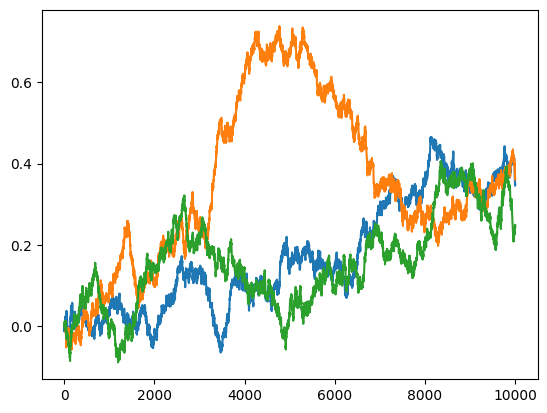

In [15]:
import numpy as np
import pandas as pd

def nonlinear_simulation(G, deltaT, RandInput, options):
    """
    Simulate the dynamics of a nonlinear system.

    Parameters:
    - G (numpy.ndarray): Connectivity matrix.
    - deltaT (float): Integration step.
    - RandInput (float): Magnitude of noisy input.
    - options (dict): Dictionary with keys 'nonlinearity', 'parameter', and 'Ttotal'.

    Returns:
    - V_pre (numpy.ndarray): Time points x variables.
    """

    def relu(x, param):
        """ReLU activation function with a given parameter."""
        Fx = x - param
        Fx[Fx < 0] = 0
        return Fx

    def sigmoid(x, param):
        """Sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x))

    def sigmoid_sym(x, param):
        """Symmetric sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x)) - 0.5

    # Select the nonlinearity function based on options
    if options['nonlinearity'] == 'relu':
        print('ReLU nonlinearity')
        F = lambda x: relu(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid':
        print('Sigmoid nonlinearity')
        F = lambda x: sigmoid(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid_sym':
        print('Sigmoid symmetric nonlinearity')
        F = lambda x: sigmoid_sym(x, options['parameter'])
    else:
        raise ValueError("Unsupported nonlinearity function")

    N = G.shape[0]
    T = int(options['Ttotal'] / deltaT)  # Number of time steps
    V_pre = np.zeros((T, N))
    I = np.zeros((T, N))

    for t in range(1, T):
        u = np.random.randn(N) * RandInput
        I[t, :] = (G @ F(V_pre[t-1, :]))  # Matrix-vector multiplication
        V_pre[t, :] = V_pre[t-1, :] + (I[t, :] + u) * deltaT

        if np.any(V_pre[t, :] > 10000):
            print('Simulation exploded')
            break

        if t % (T // 10) == 0:
            print(f'Simulation iteration: {t / T:.2f}')

    return V_pre

# Example usage
    # G = np.array([[1, 0.5, 0.5],
    #               [0.5, 1, 0.5],
    #               [0.5, 0.5, 1]])
G = np.array([[0, -0.5, -0.5],
              [-0.5, 0, 0.5],
              [-0.5, 0.5, 0]])
deltaT = 0.1 #03 #*#
RandInput = 0.04
options = {
    'nonlinearity': 'relu',  # 'sigmoid' or 'sigmoid_sym'
    'parameter': 1,
    'Ttotal': 1000
}

V_pre = nonlinear_simulation(G, deltaT, RandInput, options)

# Plotting the results
import matplotlib.pyplot as plt

plt.plot(V_pre)
plt.show()


In [104]:
pd.DataFrame(V_pre).shape

(10000, 3)

## Code for the relu estimation

### Translated from matlab code: https://github.com/yschen13/DDC/tree/main
#### Improved over prior translation: https://github.com/margotwagner/DDC/blob/main/src/py_DDC/Compute_DDC.py

In [17]:


def derivative_123(f, dm, dt):
    """
    Compute the first, second, and third derivatives of a function.
    Parameters:
    - f (numpy.ndarray): Array of function values.
    - dm (int): Parameter for the derivative calculation.
    - dt (float): Time step size.
    Returns:
    - D1 (numpy.ndarray): First derivative.
    - D2 (numpy.ndarray): Second derivative.
    - D3 (numpy.ndarray): Third derivative.
    """
    t = np.arange(1 + dm, len(f) - dm)
    # for this function to work f has to be a numpy array
    f = np.array(f)
    # D1 (First Derivative)
    D1 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = -((f[t - n2] * n1**3 - f[t + n2] * n1**3 -
                f[t - n1] * n2**3 + f[t + n1] * n2**3))
            denominator = (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
            D1 += numerator / denominator
    D1 /= d

    # D2 (Second Derivative)
    D2 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
                         f[t - n1] * n2**4 - f[t + n1] * n2**4 -
                         2 * f[t] * (n1**4 - n2**4))
            denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
            D2 += numerator / denominator
    D2 /= d

    # D3 (Third Derivative)
    D3 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            for n3 in range(n2 + 1, dm + 1):
                d += 1
                numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
                                  f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
                                  n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
                                        f[t + n2] * (n1**5 - n1 * n3**4) +
                                        f[t - n2] * (-n1**5 + n1 * n3**4))))
                denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
                D3 += numerator / denominator

    D3 /= d
    return D1, D2, D3



def dCov_numerical(cx, h, dm=4):
  """
  Compute various numerical differential covariance matrices using different finite difference methods (derivative approximations).

  Parameters:
  - cx (numpy.ndarray): Time series data matrix (T x N).
  - h (float): Step size for numerical differentiation.
  - dm (int, optional): Maximum window size for custom derivative computation. Default is 4.

  Returns:
  - dCov1 (numpy.ndarray): Differential covariance using first difference method (N x N) [approximation of first derivatie].
  - dCov2 (numpy.ndarray): Differential covariance using central difference method (N x N) [approximation of second derivative].
  - dCov5 (numpy.ndarray): Differential covariance using a higher-order difference method (N x N) [approximation of five-point stencil approximation].
  - dCov_center (numpy.ndarray): Differential covariance using a custom centered method (N x N) [the centered derivative from Taylor expansion].

  NOTE:
  	dCov = <dv/dt,v>
  	covariance is computed through np.cov()
  """
  T, N = cx.shape
  # Compute first-order derivative
  cx = np.array(cx)
  diff_cx = np.vstack(((cx[1:, :] - cx[:-1, :]) / h,
                       np.mean(cx[1:, :] - cx[:-1, :], axis=0)))
  Csample = np.cov(np.hstack((diff_cx, cx)).T, rowvar=False)
  dCov1 = zscore(Csample[:N, N:N + N])

  # Compute second-order derivative
  diff_cx = np.vstack(((1/2 * cx[2:, :] - 1/2 * cx[:-2, :]) / h,
                       np.mean(1/2 * cx[2:, :] - 1/2 * cx[:-2, :], axis=0),
                       diff_cx[-1, :]))
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov2 = zscore(Csample[:N, N:N + N])

  # Compute five-point stencil derivative
  diff_cx = np.zeros((T, N))
  for i in range(2, T - 2):
      for j in range(2, N - 2):
        diff_cx[i, j] = (
            -cx[i + 2, j] + 8 * cx[i + 1, j]
            - 8 * cx[i - 1, j] + cx[i - 2, j]
        ) / 12.0
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov5 = Csample[:N, N:N + N]

  # Compute centered derivative using derivative_123
  diff_cx = np.zeros(((T - 2 * dm)-1, N))
  for i in range(N):
      dx, _, _ = derivative_123(cx[:, i], dm, h)
      diff_cx[:, i] = dx
  cx_trunc = cx[1+dm:T - dm, :]
  Csample = np.cov(np.hstack((diff_cx, cx_trunc)), rowvar=False)
  dCov_center = Csample[:N, N:N + N]

  return dCov1, dCov2, dCov5, dCov_center


def estimators(V, thres, TR):
  """
	INPUT:
  		V_obs: time points x variables
  		thres: Relu offset
  		TR: sampling interval (seconds)
  OUTPUT:
  		B: ReLu(x),x
  		dCov: dx/dt,x
  """
  T, N = V.shape
  V_obs = zscore(V, axis=0)
  Cov = np.cov(V_obs, rowvar=False)
  precision = np.linalg.inv(Cov)
  # ReLU transformation
  Fx = np.maximum(V_obs - thres, 0)
  B = np.cov(Fx,rowvar=False)
  dV = np.diff(V_obs) / TR
  dV = np.vstack([np.mean(dV, axis=0), dV[1:-1], np.mean(dV, axis=0)])
  dCov = np.cov(np.hstack([dV, V_obs]), rowvar=False)

  return Cov, precision, B, dCov


import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import zscore

def dCov_linear_Reg(V, TR, lambda_=0.01):
    """
    L2 Regularized version of deltaL.

    Parameters:
    - V (numpy.ndarray): Time series data (T x N).
    - TR (float): Sampling interval.
    - lambda_ (float): Regularization strength.

    Returns:
    - Delta_L (numpy.ndarray): Linear DDC with ridge regularization.
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)
    Cov, _, _, _ = estimators(V_obs, 0, TR)

    # Use Cov for B as per the MATLAB code
    B = Cov
    C = dCov2

    # Initialize the output matrix
    Delta_L = np.zeros_like(C)

    # Perform ridge regression for each row of C
    BtB = B.T @ B
    identity = np.eye(B.shape[1])
    BtB_reg = BtB + lambda_ * identity
    BtB_reg_inv = np.linalg.inv(BtB_reg)
    Delta_L = zscore(np.flipud((BtB_reg_inv @ B.T @ C.T).T))/2

    return Delta_L


def dcov_relu(V, TR, lambda_=0.01):
    """
    Regularized version of Delta_ReLU
    INPUT:
        V: time series
        TR: sampling interval
        lambda_: regularization strength
    OUTPUT:
        Delta_ReLU: nonlinear DDC with ReLU nonlinearity
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)
    # V_obs = V

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)

    # Apply ReLU non-linearity to the standardized observations
    V_relu = np.maximum(V_obs, 0)  # Applying ReLU

    # Re-compute the estimators using ReLU-transformed data
    Cov, _, B, _ = estimators(V_relu, 1, TR)

    # Ridge regression using the ReLU-transformed covariance matrix
    BtB = B.T @ B
    identity = np.eye(B.shape[1])
    BtB_reg = BtB + lambda_ * identity
    BtB_reg_inv = np.linalg.inv(BtB_reg)
    Delta_ReLU = zscore(np.flipud((BtB_reg_inv @ B.T @ dCov2.T).T))/2

    return Delta_ReLU



# Testing the estimation by trying to recover ground truth

## Ground truth figure we are trying to recover


<Axes: >

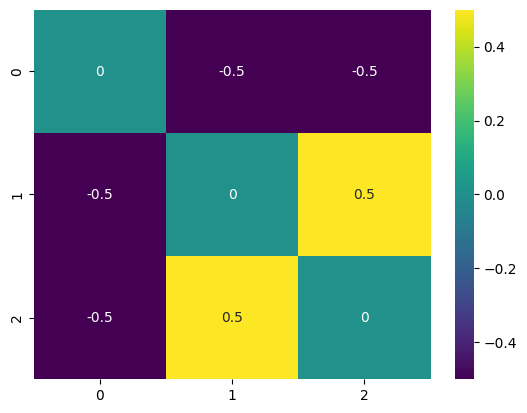

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
np.fill_diagonal(G,0)
sns.heatmap(G, annot=True, cmap = 'viridis', vmin=-0.5, vmax=0.5)

## Correlation Recovery

<Axes: >

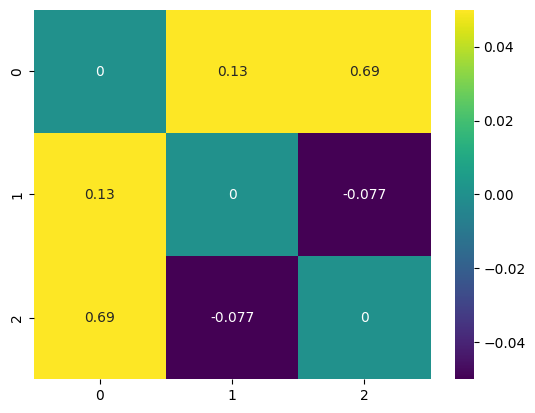

In [22]:
cor = pd.DataFrame(V_pre).corr()
np.fill_diagonal(cor.values,0)
sns.heatmap(cor, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

### Delta L Recovery

In [87]:
dCov1, dCov2,_,dCovC = dCov_numerical(V_pre, deltaT)
Cov,Precision,B,_ = estimators(V_pre, np.percentile(V_pre,50), deltaT)

<Axes: >

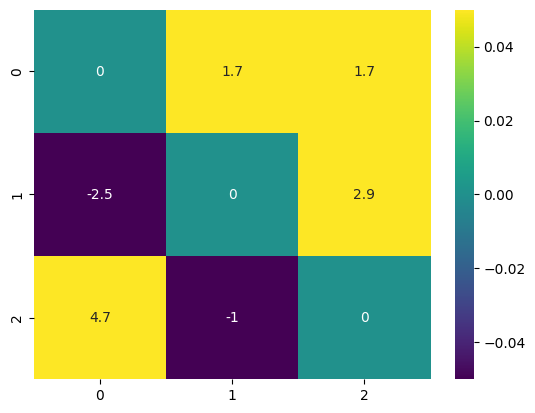

In [91]:
delta_l = np.matmul(dCov2,Precision)
delta_l_p = delta_l.copy()
np.fill_diagonal(delta_l_p,0)
sns.heatmap(delta_l_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)


### Delta Relu Recovery

<Axes: >

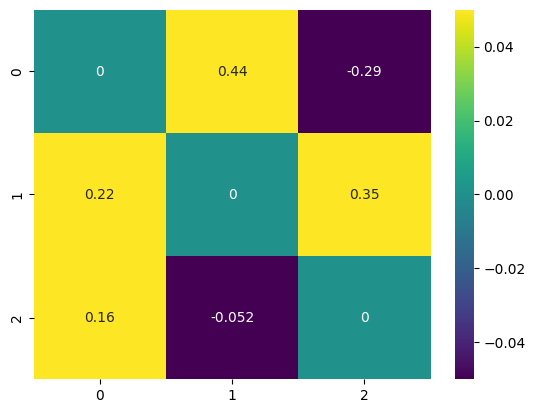

In [90]:
# delta_relu = np.matmul(dCovC,B)
# delta_relu_p = zscore(delta_relu.copy())
delta_relu = np.matmul(dCov2,B)
delta_relu_p = delta_relu.copy()
np.fill_diagonal(delta_relu_p,0)
sns.heatmap(delta_relu_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

## non-linearn ddc estimation
* ddc_relu = regularized non-linear

In [19]:
ddc_relu = dcov_relu(V=V_pre, TR=deltaT)

In [ ]:
ddc_relu

array([[ 0.69068468, -0.34784253, -0.68810007],
       [-0.21413259, -0.35923367,  0.48507739],
       [-0.4765521 ,  0.7070762 ,  0.20302268]])

In [20]:
ddc_relu = dcov_relu(V=V_pre, TR=deltaT)
ddc_relu

array([[ 0.69068468, -0.34784253, -0.68810007],
       [-0.21413259, -0.35923367,  0.48507739],
       [-0.4765521 ,  0.7070762 ,  0.20302268]])

### what we recovered - regularized non-linear (relu)

<Axes: >

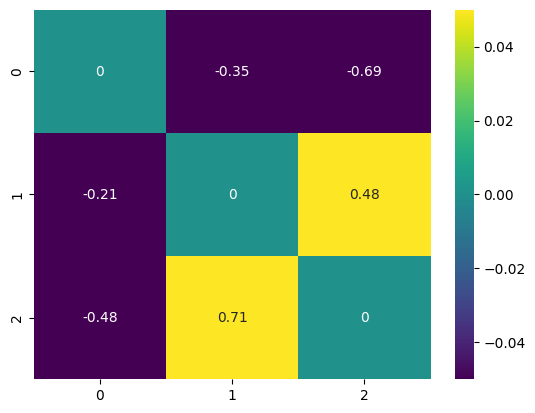

In [21]:
ddc_relu_p = ddc_relu.copy()
np.fill_diagonal(ddc_relu_p,0)
sns.heatmap(np.round(ddc_relu_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

## Linear DDC Estimation
ddc_l = linear regularized ddc


In [23]:
ddc_l = dCov_linear_Reg(V_pre, TR=0.1)

<Axes: >

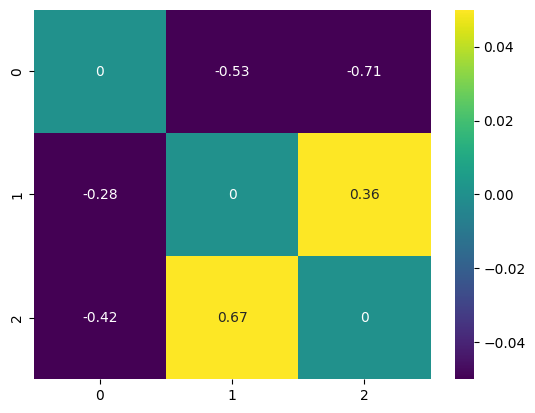

In [24]:
ddc_l_p = ddc_l.copy()
np.fill_diagonal(ddc_l_p,0)
sns.heatmap(ddc_l_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

# Evaluating recovery

## Representational similarity function to evaluate recovery

In [36]:
from joblib import parallel_backend

def distance(m1,m2):
  distance = []
  d_norm = []
  import numpy as np
  if len(m1) == len(m2) and m1[0].shape == m2[0].shape:
    for m in range(len(m1)):
      print("Calculating distance for pair", 1+m, "/", len(m1))
      mm = np.zeros([m1[m].shape[0],m1[m].shape[1]])
      for i in range(len(m1[m])):
        for j in range(len(m1[m][i])):
          mm[i][j] = (np.linalg.norm(m2[m][i][j] - m1[m][i][j]))
      distance.append(mm)
    for m in distance:
      mm2 = np.zeros([m.shape[1],m.shape[1]])
      for i in range(len(m)):
        for j in range(len(m[i])):
          mm2[i][j] = ((m[i][j]-np.min(m))/(np.max(m) - np.min(m)))
      d_norm.append(mm2)
    return(d_norm)
  else:
    raise Warning("list are different lengths or matricies are different sizes - please fix")



# function for converting distance to similarity matricies
def dist_to_sim(d_norm):
  sim = []
  for m in d_norm:
    print("Calculating similarity for", 1+len(sim), "/", len(d_norm))
    mm = np.zeros([m.shape[0],m.shape[1]])
    for i in range(len(m)):
      for j in range(len(m[i])):
        mm[i][j] = (((np.max(np.array(m))-np.min(np.array(m)))/2) - m[i][j])
    sim.append(mm)
  return(sim)



### Demonstrating representational similarity output


#### Very similar matrix

In [62]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0, 0.5, 0.35],
              [0.45, 0, 0.5],
              [0.5, 0.5, 0]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1    2
0  0.500000  0.5 -0.5
1  0.166667  0.5  0.5
2  0.500000  0.5  0.5

 Average Similarity =  0.352

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Very different matrix

In [74]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0.2, -0.5, -0.35],
              [-0.45, 0.1, -0.5],
              [-0.5, -0.5, 0.7]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1         2
0  0.388889 -0.5 -0.333333
1 -0.444444  0.5 -0.500000
2 -0.500000 -0.5 -0.166667

 Average Similarity =  -0.228

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Calculating Similarity for each matrix

In [42]:
G

array([[ 0. , -0.5, -0.5],
       [-0.5,  0. ,  0.5],
       [-0.5,  0.5,  0. ]])

#### Correlation similarity

In [77]:
dist_cor = distance([cor],[G])
sim_cor = dist_to_sim(dist_cor)
print("\n Similarity Matrix \n", pd.DataFrame(sim_cor[0]))
print("\n Average Similarity= ", round(np.average(sim_cor[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.500000 -0.033771 -0.500000
1 -0.033771  0.500000  0.014921
2 -0.500000  0.014921  0.500000

 Average Similarity=  0.051

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Delta Relu

In [93]:
dist_ddr = distance([delta_relu],[G])
sim_ddr = dist_to_sim(dist_ddr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.135466 -0.500000  0.332406
1 -0.243452  0.121710  0.396345
2 -0.184025 -0.057771  0.500000

 Average Similarity =  0.056

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


Delta L

In [94]:
dist_ddl = distance([delta_l],[G])
sim_ddl = dist_to_sim(dist_ddl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.165169  0.161990  0.165737
1  0.191553  0.500000  0.110922
2 -0.500000  0.299648 -0.361000

 Average Similarity =  0.082

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Regularized Linear

In [78]:
dist_ddcl = distance([ddc_l],[G])
sim_ddcl = dist_to_sim(dist_ddcl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.500000  0.238728
1  0.215275  0.342765  0.339613
2  0.435453  0.294961  0.030537

 Average Similarity =  0.211

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Regularized non-linear

In [95]:
dist_ddcr = distance([ddc_relu],[G])
sim_ddcr = dist_to_sim(dist_ddcr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.296918  0.243730
1  0.099053 -0.009515  0.500000
2  0.487384  0.215649  0.221647

 Average Similarity =  0.173

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


## Cosine similarity to evaluate recovery

### Correlation


In [96]:
print(cosine_similarity(cor, G))
np.average(cosine_similarity(cor, G))

[[-0.82967103  0.69396182  0.1357092 ]
 [ 0.35033964 -0.96455632 -0.61421669]
 [ 0.07838651 -0.70274857 -0.78113509]]


-0.2926589462420968

### Regularized linear DDC

In [106]:
print(cosine_similarity(ddc_l_p, G))
np.average(cosine_similarity(ddc_l_p, G))

[[ 0.99016947 -0.56502117 -0.4251483 ]
 [-0.56054481  0.99157789  0.43103308]
 [-0.59706011  0.37883931  0.97589942]]


0.17997164286404382

### Regularized non-linear DDC

In [105]:
print(cosine_similarity(ddc_relu_p, G))
np.average(cosine_similarity(ddc_relu_p, G))

[[ 0.95006536 -0.63105817 -0.31900719]
 [-0.6468816   0.93244104  0.28555944]
 [-0.58636292  0.39519429  0.98155721]]


0.15127860797081005

In [101]:
print(cosine_similarity(delta_l, G))
np.average(cosine_similarity(delta_l, G))

[[-0.73695465  0.8445379   0.84832833]
 [-0.41194248  0.98472993  0.34532642]
 [ 0.59784767 -0.98742747 -0.61220448]]


0.09691568545208223

In [102]:
print(cosine_similarity(delta_relu, G))
np.average(cosine_similarity(delta_relu, G))

[[-0.16159145  0.09255642  0.89040563]
 [ 0.05110982  0.16738093 -0.7561247 ]
 [ 0.42402683 -0.86209069 -0.84241585]]


-0.11074923055766828

# Junk / Experimental

In [ ]:
# import numpy as np
# import pandas as pd
# from numpy.linalg import inv
# from scipy.stats import zscore
# from numpy.linalg import matrix_rank
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
# import sklearn



# def estimators(V_obs, thres, TR):
#     """
#     Compute covariance, precision matrix, B matrix, and differential covariance matrix from observed data.

#     Parameters:
#     - V_obs (numpy.ndarray): Observed data matrix (T x N), where T is the number of time points and N is the number of variables.
#     - thres (float): Threshold value used to modify V_obs for B matrix computation.
#     - TR (float): Time resolution used for differential computation.

#     Returns:
#     - Cov (numpy.ndarray): Covariance matrix of the observed data (N x N).
#     - precision (numpy.ndarray): Precision matrix (inverse of Cov) (N x N).
#     - B (numpy.ndarray): Covariance between thresholded data and observed data (N x N).
#     - dCov (numpy.ndarray): Differential covariance matrix (N x N).
#     """
#     T, N = np.shape(V_obs)
#     Cov = np.cov(V_obs, rowvar=False)
#     precision = inv(Cov)
#     Fx = V_obs - thres
#     Fx[Fx < 0] = 0
#     tmp = np.hstack((Fx, V_obs))
#     B_tmp = np.cov(tmp, rowvar=False)
#     B = B_tmp[0:N, N:]
#     dV = np.array(((-1 / 2 * V_obs[0:-2, :] + 1 / 2 * V_obs[2:, :])) / TR)
#     rowmean = np.mean(dV, axis=0)
#     dV = np.vstack([rowmean, dV, rowmean])
#     tmp_2 = np.hstack((dV, V_obs))
#     dCov = tmp_2[0:N, N + 1 :]

#     return Cov, precision, B, dCov

# def derivative_123(f, dm, dt):
#     """
#     Compute the first numerical derivative using a custom method based on window sizes and time differences.

#     Parameters:
#     - f (numpy.ndarray): Input time series data.
#     - dm (int): Maximum window size for derivative computation.
#     - dt (float): Time step size.

#     Returns:
#     - D1 (float): First derivative result.
#     - D2 (float): Second derivative result.
#     - D3 (float): Third derivative result.
#     """
#     t = np.arange(dm, len(f) - dm)
#     # D1 (First Derivative)
#     D1, d1 = 0, 0

#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d1 += 1
#             D1 += -((
#                 f[t - n2] * n1**3 - f[t + n2] * n1**3 - f[t - n1] * n2**3 + f[t + n1] * n2**3
#             ) / (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3))

#     D1 /= d1

#     # D2 (Second Derivative)
#     D2, d2 = 0, 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d2 += 1
#             numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
#                          f[t - n1] * n2**4 - f[t + n1] * n2**4 -
#                          2 * f[t] * (n1**4 - n2**4))
#             denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
#             D2 += numerator / denominator
#     D2 /= d2

#     # D3 (Third Derivative)
#     D3, d3 = 0, 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             for n3 in range(n2 + 1, dm + 1):
#                 d3 += 1
#                 numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
#                                   f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
#                                   n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
#                                         f[t + n2] * (n1**5 - n1 * n3**4) +
#                                         f[t - n2] * (-n1**5 + n1 * n3**4))))
#                 denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
#                 D3 += numerator / denominator
#     D3 /= d3
#     return D1, D2, D3

# # def derivative_123(f, dm, dt):
# #     """
# #     Compute the first numerical derivative using a custom method based on window sizes and time differences.

# #     Parameters:
# #     - f (numpy.ndarray): Input time series data.
# #     - dm (int): Maximum window size for derivative computation.
# #     - dt (float): Time step size.

# #     Returns:
# #     - D1 (float): First derivative result.
# #     - D2 (float): Second derivative result.
# #     - D3 (float): Third derivative result.
# #     """
# #     t = np.arange(dm, len(f) - dm)
# #     D1, D2, D3 = 0, 0, 0
# #     d1, d2, d3 = 0, 0, 0
# #     for n1 in range(1, dm + 1):
# #         # n1i = n1 - 1
# #         for n2 in range(n1 + 1, dm + 1):
# #             # n2i = n2 - 1
# #             d1 += 1
# #             D1 += -(
# #                 (
# #                     f[t - n2] * n1**3
# #                     - f[t + n2] * n1**3
# #                     - f[t - n1] * n2**3
# #                     + f[t + n1] * n2**3
# #                 )
# #                 / (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
# #             )
# #             """
# #             for n3 in range(n2 + 1, dm + 1):
# #                 #n3i = n3-1
# #                 d3 += 1
# #                 D3 += (3 * (f[t - n3i] * n1 * n2 * (n1 ** 4 - n2 ** 4) +
# #                             f[t + n3i] * (-(n1 ** 5 * n2) + n1 * n2 ** 5) +
# #                             n3 * ((f[t - n1i] - f[t + n1i]) * n2 * (n2 ** 4 - n3 ** 4) +
# #                                   f[t + n2i] * (n1 ** 5 - n1 * n3 ** 4) + f[t - n2i] * (-n1 ** 5 + n1 * n3 ** 4)))) / \
# #                       (dt ** 3 * n1 * (n1 ** 2 - n2 ** 2) * n3 * (n1 ** 2 - n3 ** 2) * (n2 ** 3 - n2 * n3 ** 2))

# #             d2 += 1
# #             D2 += (f[t - n2i] * n1 ** 4 + f[t + n2i] * n1 ** 4 - f[t - n1i] * n2 ** 4 - f[t + n1i] * n2 ** 4 -
# #                    2 * f[t] * (n1 ** 4 - n2 ** 4)) / \
# #                   (dt ** 2 * n2 ** 2 * (n1 ** 4 - n1 ** 2 * n2 ** 2))
# #             """
# #     D1 = D1 / d1
# #     # D2 = D2 / d2
# #     # D3 = D3 / d3

# #     return D1, D2, D3


# def dCov_numerical(cx, h, dm=4):
#     """
#     Compute various numerical differential covariance matrices using different finite difference methods.

#     Parameters:
#     - cx (numpy.ndarray): Time series data matrix (T x N).
#     - h (float): Step size for numerical differentiation.
#     - dm (int, optional): Maximum window size for custom derivative computation. Default is 4.

#     Returns:
#     - dCov1 (numpy.ndarray): Differential covariance using first difference method (N x N).
#     - dCov2 (numpy.ndarray): Differential covariance using central difference method (N x N).
#     - dCov5 (numpy.ndarray): Differential covariance using a higher-order difference method (N x N).
#     - dCov_center (numpy.ndarray): Differential covariance using a custom centered method (N x N).
#     """
#     T, N = np.shape(cx)
#     diff_cx = np.array((cx[1:, :] - cx[0:-1, :]) / h)
#     rowmean = np.mean(diff_cx, axis=0)
#     diff_cx = np.vstack([diff_cx, rowmean])
#     Csample = np.cov(np.hstack((diff_cx, cx)).T)
#     dCov1 = Csample[0:N, N : N + N]

#     diff_cx = np.array((1 / 2 * cx[2:, :] - (1 / 2 * cx[0:-2, :])) / h)
#     rowmean = np.mean(diff_cx, axis=0)
#     diff_cx = np.vstack([rowmean, diff_cx, rowmean])
#     Csample = np.cov(np.hstack((diff_cx, cx)).T)
#     dCov2 = Csample[0:N, N : N + N]

#     diff_cx = np.array(
#         (-cx[4:, :] + 8 * cx[3:-1, :] - 8 * cx[1:-3, :] + cx[:-4, :]) / (12 * h)
#     )
#     rowmean = np.mean(diff_cx, axis=0)
#     diff_cx = np.vstack([rowmean, rowmean, diff_cx, rowmean, rowmean])
#     Csample = np.cov(np.hstack((diff_cx, cx)).T)
#     dCov5 = Csample[0:N, N : N + N]

#     diff_cx = None
#     for i in range(N):
#         dx, _, _ = derivative_123(cx[:, i], dm, h)
#         if diff_cx is None:
#             diff_cx = dx
#         else:
#             diff_cx = np.c_[diff_cx, dx]
#     cx_trunc = cx[dm : T - dm, :]
#     Csample = np.cov(np.hstack((diff_cx, cx_trunc)).T)
#     dCov_center = Csample[:N, N : N + N]

#     return dCov1, dCov2, dCov5, dCov_center


# def prctile(x, p):
#     """
#     Compute percentiles for an array using an adjusted scale to handle edge cases.

#     Parameters:
#     - x (numpy.ndarray): Input array of data.
#     - p (float or array-like): Percentile(s) to compute.

#     Returns:
#     - (numpy.ndarray): Percentile value(s) of the input array.
#     """
#     p = np.asarray(p, dtype=float)
#     n = len(x)
#     p = (p - 50) * n / (n - 1) + 50
#     p = np.clip(p, 0, 100)

#     return np.percentile(x, p)


# def compute_ddc(ts, TR, d):
#     """
#     Compute Dynamical Differential Covariance (DDC) and its regularized versions.

#     Parameters:
#     - ts (numpy.ndarray): Time series data (T x N).
#     - TR (float): Time resolution of the data.
#     - d (int or str): Type of differential covariance to use; 2 for `dCov2`, "c" for `dCov_center`.

#     Returns:
#     - Cov (numpy.ndarray): Covariance matrix of the time series (N x N).
#     - DDC (numpy.ndarray): Dynamical Differential Covariance matrix (N x N).
#     - Reg_DDC (numpy.ndarray): Regularized DDC matrix using ridge regression (N x N).
#     - nl_DDC (numpy.ndarray): Non-linear DDC estimator (N x N).
#     - qc_flag (int): Quality control flag indicating if the covariance matrix is rank deficient (0 = no issue, 1 = rank deficient).
#     """
#     if np.max(ts[0, :]) == ts[0, -1] and np.min(ts[0, :]) == ts[0, 0]:
#         ts = ts[1:, :]

#     T, N = ts.shape
#     V_obs = zscore(ts, ddof=1)
#     dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR)
#     Cov, Precision, B, _ = estimators(V_obs, 0, TR)

#     if matrix_rank(Cov) < len(Cov):
#         print("Cov is rank deficient!")
#         qc_flag=1
#     else:
#         qc_flag=0

#     if d == 2:  # using dCov2
#         DDC = dCov2 @ Precision  # Delta L
#         nl_DDC = dCov2 @ B  # Delta ReLu

#         C = dCov2
#         B = Cov
#         Reg_DDC = np.zeros(np.shape(C))

#         l = 1e-2
#         Bb = sklearn.preprocessing.scale(B)

#         for n in range(len(C)):
#             ci = C[n, :]
#             ridgereg = Ridge(alpha=l)
#             ridgereg.fit(Bb, ci.T)
#             coef = ridgereg.coef_
#             Reg_DDC[n, :] = coef.T

#     elif d == "c":  # using dCov_center
#         DDC = dCov_center @ Precision  # Delta L
#         nl_DDC = dCov_center @ B  # Delta ReLu

#         C = dCov_center
#         B = Cov
#         Reg_DDC = np.zeros(np.shape(C))

#         l = 1e-2
#         Bb = sklearn.preprocessing.scale(B)
#         for n in range(len(C)):
#             ci = C[n, :]
#             ridgereg = Ridge(alpha=l)
#             ridgereg.fit(Bb, ci.T)
#             coef = ridgereg.coef_
#             Reg_DDC[n, :] = coef.T

#     return Cov, sklearn.preprocessing.scale(DDC), sklearn.preprocessing.scale(Reg_DDC), sklearn.preprocessing.scale(nl_DDC), qc_flag



In [ ]:
# th_ddc = compute_ddc(V_pre, deltaT,2)

Ground Truth


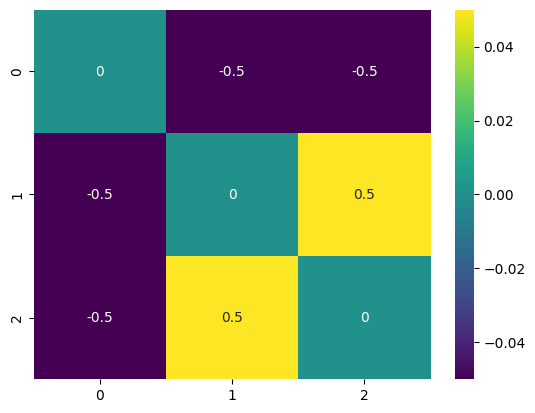

Cov


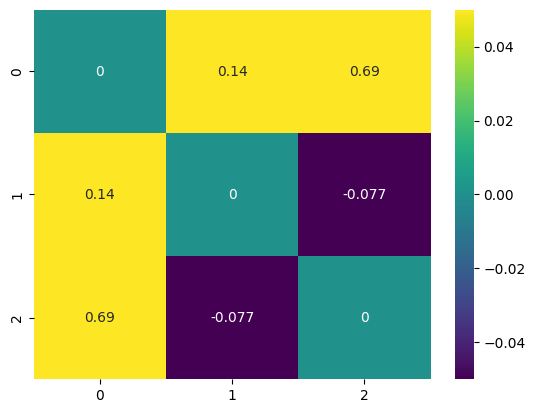

DDC


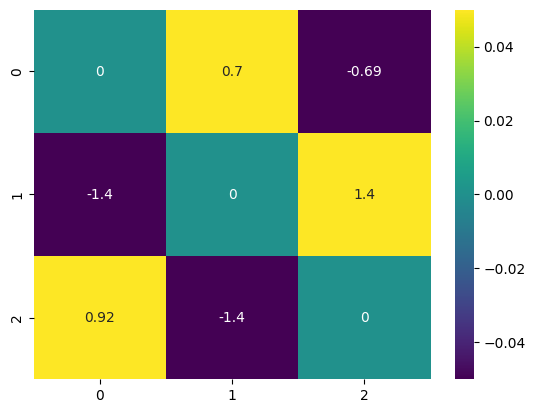

Reg_DDC


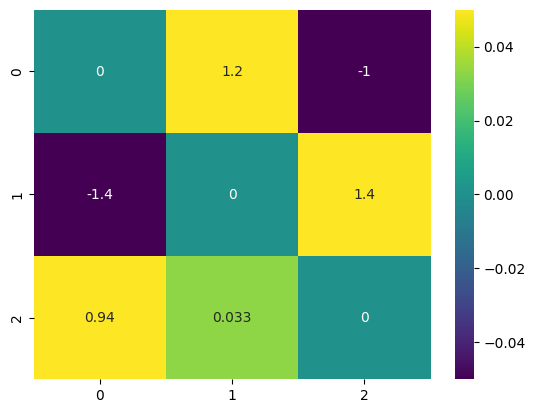

nl_DDC


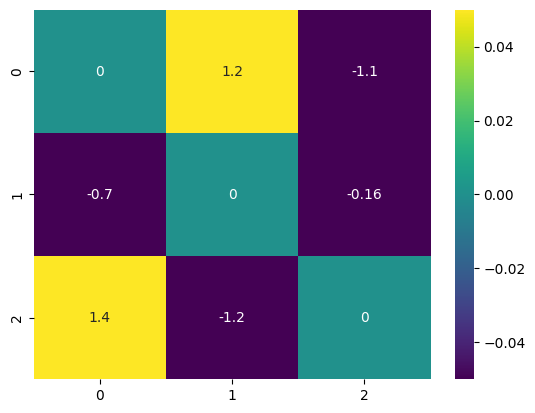

In [ ]:
# estimator = ["Cov", "DDC", "Reg_DDC", "nl_DDC"]
# th_ddc = compute_ddc(V_pre, deltaT, 2)
# print("Ground Truth")
# sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)
# plt.show()
# for i in range(len(th_ddc)-1):
#   pp = th_ddc[i]
#   np.fill_diagonal(pp,0)
#   print(estimator[i])
#   sns.heatmap(np.round(pp,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)
#   plt.show()

In [ ]:
# dCov1, dCov2,_,dCovC = dCov_numerical(V_pre, deltaT)
# Cov,Precision,B,_ = estimators(V_pre, np.percentile(V_pre,50), deltaT)

In [ ]:
# B

array([[ 9.97161151e-03, -1.98559526e-03,  6.09884064e-03],
       [ 9.97710015e-05,  3.47846662e-02, -4.35186645e-03],
       [ 4.98755863e-03, -1.54228051e-03,  4.92672789e-03]])

In [ ]:
# dCov1

array([[-7.68476930e-05,  1.38657970e-05, -3.30430684e-05],
       [-7.00434802e-05, -1.40273880e-04,  1.62477510e-05],
       [ 2.08350092e-05, -7.00145003e-05, -8.81346022e-05]])

In [ ]:
# dCov2

array([[ 1.32628246e-06,  1.28353279e-05, -3.25960082e-05],
       [-7.01625674e-05, -6.09053269e-05,  1.64244157e-05],
       [ 2.14489897e-05, -6.98126646e-05, -8.40266130e-06]])

In [ ]:
# G

array([[ 0. , -0.5, -0.5],
       [-0.5,  0. ,  0.5],
       [-0.5,  0.5,  0. ]])

In [ ]:
# delta_l = np.matmul(dCovC,Precision)
# delta_l

array([[ 4.56197362e-05, -1.90697214e-06, -6.55287594e-05],
       [-1.42297592e-04, -3.25691927e-05,  1.12747868e-04],
       [ 8.44144316e-05, -8.45104971e-05, -7.16253103e-05]])

In [ ]:
# delta_relu = np.matmul(dCovC,B)
# delta_relu

array([[-8.48020224e-06,  6.19611544e-06, -1.11046594e-05],
       [-1.01111094e-05, -1.07911334e-05, -3.59495947e-06],
       [ 1.36554511e-05, -2.12049482e-05,  1.02657247e-05]])

In [ ]:
# https://github.com/margotwagner/DDC/blob/main/src/py_DDC/Compute_DDC.py
# import numpy as np
# from numpy.linalg import inv, matrix_rank
# from scipy.stats import zscore
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import scale
# # from fracdiff import fdiff


# def estimators(V_obs, thres, TR):
#     """
#     Compute covariance, precision matrix, B matrix, and differential covariance matrix from observed data.

#     Parameters:
#     - V_obs (numpy.ndarray): Observed data matrix (T x N), where T is the number of time points and N is the number of variables.
#     - thres (float): Threshold value used to modify V_obs for B matrix computation.
#     - TR (float): Time resolution used for differential computation.

#     Returns:
#     - Cov (numpy.ndarray): Covariance matrix of the observed data (N x N).
#     - precision (numpy.ndarray): Precision matrix (inverse of Cov) (N x N).
#     - B (numpy.ndarray): Covariance between thresholded data and observed data (N x N).
#     - dCov (numpy.ndarray): Differential covariance matrix (N x N).
#     """
#     T, N = V_obs.shape
#     Cov = np.cov(V_obs, rowvar=False)
#     precision = inv(Cov)

#     # Threshold and compute B matrix
#     Fx = np.maximum(V_obs - thres, 0)
#     B_tmp = np.cov(np.hstack((Fx, V_obs)), rowvar=False)
#     B = B_tmp[:N, N:]

#     # Compute differential covariance
#     dV = (-0.5 * V_obs[:-2, :] + 0.5 * V_obs[2:, :]) / TR
#     rowmean = np.mean(dV, axis=0)
#     dV = np.vstack([rowmean, dV, rowmean])

#     dCov = np.cov(np.hstack((dV, V_obs)), rowvar=False)[0:N, N:]

#     return Cov, precision, B, dCov


# def derivative_123(f, dm, dt):
#     """
#     Compute the first numerical derivative using a custom method based on window sizes and time differences.

#     Parameters:
#     - f (numpy.ndarray): Input time series data.
#     - dm (int): Maximum window size for derivative computation.
#     - dt (float): Time step size.

#     Returns:
#     - D1 (float): First derivative result.
#     - D2 (float): Second derivative result.
#     - D3 (float): Third derivative result.
#     """
#     t = np.arange(dm, len(f) - dm)
#     # D1 (First Derivative)
#     D1, d1 = 0, 0

#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d1 += 1
#             D1 += -((
#                 f[t - n2] * n1**3 - f[t + n2] * n1**3 - f[t - n1] * n2**3 + f[t + n1] * n2**3
#             ) / (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3))

#     D1 /= d1

#     # D2 (Second Derivative)
#     D2, d2 = 0, 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d2 += 1
#             numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
#                          f[t - n1] * n2**4 - f[t + n1] * n2**4 -
#                          2 * f[t] * (n1**4 - n2**4))
#             denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
#             D2 += numerator / denominator
#     D2 /= d2

#     # D3 (Third Derivative)
#     D3, d3 = 0, 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             for n3 in range(n2 + 1, dm + 1):
#                 d3 += 1
#                 numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
#                                   f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
#                                   n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
#                                         f[t + n2] * (n1**5 - n1 * n3**4) +
#                                         f[t - n2] * (-n1**5 + n1 * n3**4))))
#                 denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
#                 D3 += numerator / denominator
#     D3 /= d3
#     return D1, D2, D3


# def dCov_numerical(cx, h, dm=4):
#     """
#     Compute various numerical differential covariance matrices using different finite difference methods.

#     Parameters:
#     - cx (numpy.ndarray): Time series data matrix (T x N).
#     - h (float): Step size for numerical differentiation.
#     - dm (int, optional): Maximum window size for custom derivative computation. Default is 4.

#     Returns:
#     - dCov1 (numpy.ndarray): Differential covariance using first difference method (N x N).
#     - dCov2 (numpy.ndarray): Differential covariance using central difference method (N x N).
#     - dCov5 (numpy.ndarray): Differential covariance using a higher-order difference method (N x N).
#     - dCov_center (numpy.ndarray): Differential covariance using a custom centered method (N x N).
#     """
#     T, N = cx.shape
#     diff_methods = [
#         (cx[1:, :] - cx[:-1, :]) / h,
#         (0.5 * cx[2:, :] - 0.5 * cx[:-2, :]) / h,
#         (-cx[4:, :] + 8 * cx[3:-1, :] - 8 * cx[1:-3, :] + cx[:-4, :]) / (12 * h)
#     ]

#     dCov_results = []
#     for diff_cx in diff_methods:
#         rowmean = np.mean(diff_cx, axis=0)
#         diff_cx = np.vstack([rowmean] * (cx.shape[0] - diff_cx.shape[0]) + [diff_cx])
#         dCov_results.append(np.cov(np.hstack((diff_cx, cx)).T)[0:N, N:N + N])
#         # diff_cx = np.vstack([rowmean] * (len(diff_methods) - len(diff_cx) % len(diff_methods)) + [diff_cx])
#         # dCov_results.append(np.cov(np.hstack((diff_cx, cx)).T)[0:N, N:N + N])

#     # Custom centered differential covariance
#     diff_cx = np.column_stack([derivative_123(cx[:, i], dm, h)[0] for i in range(N)])
#     Csample = np.cov(np.hstack((diff_cx, cx[dm:T - dm, :])).T)
#     dCov_center = Csample[:N, N:N + N]

#     return *dCov_results, dCov_center


# def prctile(x, p):
#     """
#     Compute percentiles for an array using an adjusted scale to handle edge cases.

#     Parameters:
#     - x (numpy.ndarray): Input array of data.
#     - p (float or array-like): Percentile(s) to compute.

#     Returns:
#     - (numpy.ndarray): Percentile value(s) of the input array.
#     """
#     n = len(x)
#     p = np.clip((p - 50) * n / (n - 1) + 50, 0, 100)
#     return np.percentile(x, p)


# def compute_ddc(ts, TR, d):
#     """
#     Compute Dynamical Differential Covariance (DDC) and its regularized versions.

#     Parameters:
#     - ts (numpy.ndarray): Time series data (T x N).
#     - TR (float): Time resolution of the data.
#     - d (int or str): Type of differential covariance to use; 2 for `dCov2`, "c" for `dCov_center`.

#     Returns:
#     - Cov (numpy.ndarray): Covariance matrix of the time series (N x N).
#     - DDC (numpy.ndarray): Dynamical Differential Covariance matrix (N x N).
#     - Reg_DDC (numpy.ndarray): Regularized DDC matrix using ridge regression (N x N).
#     - nl_DDC (numpy.ndarray): Non-linear DDC estimator (N x N).
#     - qc_flag (int): Quality control flag indicating if the covariance matrix is rank deficient (0 = no issue, 1 = rank deficient).
#     """
#     if np.max(ts[0, :]) == ts[0, -1] and np.min(ts[0, :]) == ts[0, 0]:
#         ts = ts[1:, :]

#     V_obs = zscore(ts, ddof=1)
#     dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR)
#     Cov, Precision, B, _ = estimators(V_obs, 0, TR)

#     qc_flag = int(matrix_rank(Cov) < len(Cov))
#     if qc_flag:
#         print("Cov is rank deficient!")

#     if d == 2:
#         C, dCov, DDC = dCov2, dCov2 @ Precision, dCov2 @ B
#     elif d == "c":
#         C, dCov, DDC = dCov_center, dCov_center @ Precision, dCov_center @ B
#     else:
#         return Cov, None, None, None, qc_flag

#     # Regularize DDC using ridge regression
#     Reg_DDC = np.array([Ridge(alpha=1e-2).fit(scale(Cov), C[n, :]).coef_ for n in range(len(C))])

#     return Cov, DDC, Reg_DDC, dCov, qc_flag


# def compute_fddc(ts, TR, d):
#     """
#     Compute Fractional Dynamical Differential Covariance (FDDC) and its regularized version.

#     Parameters:
#     - ts (numpy.ndarray): Time series data (T x N).
#     - TR (float): Time resolution of the data.
#     - d (float): Fractional differentiation order.

#     Returns:
#     - FDDC (numpy.ndarray): Fractional Dynamical Differential Covariance matrix (N x N).
#     - Reg_FDDC (numpy.ndarray): Regularized FDDC matrix using ridge regression (N x N).
#     """
#     if np.max(ts[0, :]) == ts[0, -1] and np.min(ts[0, :]) == ts[0, 0]:
#         ts = ts[1:, :]

#     V_obs = zscore(ts, ddof=1)
#     diff_cx = fdiff(V_obs, d, axis=0)
#     dFrac = np.cov(np.hstack((diff_cx, ts)).T)[0:V_obs.shape[1], V_obs.shape[1]:]

#     Cov, Precision, B, _ = estimators(V_obs, 0, TR)
#     FDDC = dFrac @ Precision
#     Reg_FDDC = np.array([Ridge(alpha=1e-2).fit(scale(Cov), FDDC[n, :]).coef_ for n in range(len(FDDC))])

#     return FDDC, Reg_FDDC


In [ ]:
### Recent optomized versions - needs a little work
# import numpy as np

# def derivative_123(f, dm, dt):
#     """
#     Compute the first, second, and third derivatives of a function.
#     Parameters:
#     - f (numpy.ndarray): Array of function values.
#     - dm (int): Parameter for the derivative calculation.
#     - dt (float): Time step size.
#     Returns:
#     - D1 (numpy.ndarray): First derivative.
#     - D2 (numpy.ndarray): Second derivative.
#     - D3 (numpy.ndarray): Third derivative.
#     """
#     t = np.arange(1 + dm, len(f) - dm)

#     # Precompute some constant factors
#     n1_range = np.arange(1, dm + 1)
#     n2_range = np.arange(2, dm + 1)
#     n3_range = np.arange(3, dm + 1)

#     # Vectorized D1 (First Derivative)
#     D1 = np.sum([(-((f[t - n2] * n1**3 - f[t + n2] * n1**3 -
#                     f[t - n1] * n2**3 + f[t + n1] * n2**3)) /
#                 (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3))
#                 for n1 in n1_range for n2 in range(n1 + 1, dm + 1)], axis=0)
#     D1 /= (dm * (dm - 1) / 2)

#     # Vectorized D2 (Second Derivative)
#     D2 = np.sum([((f[t - n2] * n1**4 + f[t + n2] * n1**4 -
#                   f[t - n1] * n2**4 - f[t + n1] * n2**4 -
#                   2 * f[t] * (n1**4 - n2**4)) /
#                 (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2)))
#                 for n1 in n1_range for n2 in range(n1 + 1, dm + 1)], axis=0)
#     D2 /= (dm * (dm - 1) / 2)

#     # Vectorized D3 (Third Derivative)
#     D3 = np.sum([((3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
#                         f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
#                         n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
#                               f[t + n2] * (n1**5 - n1 * n3**4) +
#                               f[t - n2] * (-n1**5 + n1 * n3**4)))) /
#                 (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2)))
#                 for n1 in n1_range for n2 in range(n1 + 1, dm + 1) for n3 in range(n2 + 1, dm + 1)], axis=0)
#     D3 /= (dm * (dm - 1) * (dm - 2) / 6)

#     return D1, D2, D3


# import numpy as np
# from scipy.stats import zscore

# def dCov_numerical(cx, h, dm=4):
#     """
#     Compute linear dCov using numerical derivatives.

#     Parameters:
#     - cx (numpy.ndarray): T x N array of data.
#     - h (float): Sampling interval.
#     - dm (int): Averaging window parameter (default is 4 unless specified).

#     Returns:
#     - dCov1 (numpy.ndarray): Covariance for the first derivative.
#     - dCov2 (numpy.ndarray): Covariance for the second derivative.
#     - dCov5 (numpy.ndarray): Covariance for the five-point stencil approximation.
#     - dCov_center (numpy.ndarray): Covariance for the centered derivative from Taylor expansion.
#     NOTE:
#         dCov = <dv/dt,v>
#         covariance is computed through cov()
#     """
#     T, N = cx.shape

#     # Compute first-order derivative
#     diff_cx1 = (cx[1:, :] - cx[:-1, :]) / h
#     diff_cx1 = np.vstack((diff_cx1, np.mean(diff_cx1, axis=0)))
#     Csample1 = np.cov(np.hstack((diff_cx1, cx)).T, rowvar=False)
#     dCov1 = zscore(Csample1[:N, N:N + N])

#     # Compute second-order derivative
#     diff_cx2 = (cx[2:, :] - cx[:-2, :]) / (2 * h)
#     diff_cx2 = np.vstack((diff_cx2, np.mean(diff_cx2, axis=0), diff_cx1[-1, :]))
#     Csample2 = np.cov(np.hstack((diff_cx2, cx)).T, rowvar=False)
#     dCov2 = zscore(Csample2[:N, N:N + N])

#     # Compute five-point stencil derivative
#     diff_cx5 = (-cx[4:, :] + 8 * cx[3:-1, :] - 8 * cx[1:-3, :] + cx[:-4, :]) / (12 * h)
#     diff_cx5 = np.vstack((np.zeros((2, N)), diff_cx5, np.zeros((2, N))))
#     Csample5 = np.cov(np.hstack((diff_cx5, cx)).T, rowvar=False)
#     dCov5 = Csample5[:N, N:N + N]

#     # Compute centered derivative using derivative_123
#     diff_cx_center = np.zeros(((T - 2 * dm) - 1, N))
#     for i in range(N):
#         dx, _, _ = derivative_123(cx[:, i], dm, h)
#         diff_cx_center[:, i] = dx
#     cx_trunc = cx[1+dm:T - dm, :]
#     Csample_center = np.cov(np.hstack((diff_cx_center, cx_trunc)).T, rowvar=False)
#     dCov_center = Csample_center[:N, N:N + N]

#     return dCov1, dCov2, dCov5, dCov_center


# import numpy as np
# from scipy.stats import zscore

# def estimators(V, thres, TR):
#     """
#     INPUT:
#         V: time points x variables
#         thres: ReLU offset
#         TR: sampling interval (seconds)
#     OUTPUT:
#         Cov: Covariance of the observations
#         precision: Precision matrix (inverse of Cov)
#         B: ReLU(x), x covariance
#         dCov: dx/dt, x covariance
#     """
#     T, N = V.shape

#     # Standardize V_obs
#     V_obs = zscore(V, axis=0)

#     # Compute Covariance and Precision matrix
#     Cov = np.cov(V_obs, rowvar=False)
#     precision = np.linalg.inv(Cov)

#     # ReLU transformation and its covariance
#     Fx = np.maximum(V_obs - thres, 0)
#     B = np.cov(Fx, rowvar=False)

#     # Compute derivative dV and its covariance with V_obs
#     dV = np.diff(V_obs, axis=0) / TR
#     # Prepend and append means instead of using vstack multiple times
#     dV = np.vstack([np.mean(dV, axis=0), dV, np.mean(dV, axis=0)])
#     dCov = np.cov(np.hstack([dV, V_obs]), rowvar=False)

#     return Cov, precision, B, dCov

# import numpy as np
# from sklearn.linear_model import Ridge
# from scipy.stats import zscore

# def dCov_linear_Reg(V, TR, lambda_=0.01):
#     """
#     L2 Regularized version of deltaL.

#     Parameters:
#     - V (numpy.ndarray): Time series data (T x N).
#     - TR (float): Sampling interval.
#     - lambda_ (float): Regularization strength.

#     Returns:
#     - Delta_L (numpy.ndarray): Linear DDC with ridge regularization.
#     """
#     T, N = V.shape
#     V_obs = zscore(V, axis=0)  # Standardize V

#     # Calculate numerical derivatives and estimators
#     dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR, dm=4)
#     Cov, Precision, B, _ = estimators(V_obs, 0, TR)

#     # Use the ridge regression formula: (B.T @ B + lambda_ * I)^-1 @ B.T @ C
#     BtB = B.T @ B
#     identity = np.eye(B.shape[1])
#     BtB_reg = BtB + lambda_ * identity
#     BtB_reg_inv = np.linalg.inv(BtB_reg)
#     Delta_L = (BtB_reg_inv @ B.T @ dCov2.T).T

#     return Delta_L


# def dcov_relu(V, TR, lambda_=0.01):
#     """
#     Delta_ReLU
#     INPUT:
#         V: time series
#         TR: sampling interval
#         lambda_: regularization strength
#     OUTPUT:
#         Delta_ReLU: nonlinear DDC with ReLU nonlinearity
#     """
#     T, N = V.shape

#     # Standardize V
#     V_obs = zscore(V, axis=0)
#     # V_obs = V

#     # Calculate numerical derivatives and estimators
#     _, dCov2, _, _ = dCov_numerical(V_obs, TR)

#     # Apply ReLU non-linearity to the standardized observations
#     V_relu = np.maximum(V_obs, 0)  # Applying ReLU

#     # Re-compute the estimators using ReLU-transformed data
#     Cov, _, B, _ = estimators(V_relu, 1, TR)

#     # Ridge regression using the ReLU-transformed covariance matrix
#     BtB = B.T @ B
#     identity = np.eye(B.shape[1])
#     BtB_reg = BtB + lambda_ * identity
#     BtB_reg_inv = np.linalg.inv(BtB_reg)
#     Delta_ReLU = np.flipud((BtB_reg_inv @ B.T @ dCov2.T).T)

#     return Delta_ReLU





In [ ]:
# def derivative_123(f, dm, dt):
#     """
#     Compute the first, second, and third derivatives of a function.

#     Parameters:
#     - f (numpy.ndarray): Array of function values.
#     - dm (int): Parameter for the derivative calculation.
#     - dt (float): Time step size.

#     Returns:
#     - D1 (numpy.ndarray): First derivative.
#     - D2 (numpy.ndarray): Second derivative.
#     - D3 (numpy.ndarray): Third derivative.
#     """
#     # Define the time index range
#     t = np.arange(1 + dm, len(f) - dm)

#     # Initialize derivatives
#     D1 = np.zeros_like(t, dtype=np.float64)
#     D2 = np.zeros_like(t, dtype=np.float64)
#     D3 = np.zeros_like(t, dtype=np.float64)

#     # Compute D1
#     d = 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d += 1
#             numerator = -((f[t - n2] * n1**3 - f[t + n2] * n1**3 -
#                             f[t - n1] * n2**3 + f[t + n1] * n2**3))
#             denominator = (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
#             D1 += numerator / denominator
#     D1 /= d

#     # Compute D2
#     d = 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             d += 1
#             numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
#                          f[t - n1] * n2**4 - f[t + n1] * n2**4 -
#                          2 * f[t] * (n1**4 - n2**4))
#             denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
#             D2 += numerator / denominator
#     D2 /= d

#     # Compute D3
#     d = 0
#     for n1 in range(1, dm + 1):
#         for n2 in range(n1 + 1, dm + 1):
#             for n3 in range(n2 + 1, dm + 1):
#                 d += 1
#                 numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
#                                   f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
#                                   n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
#                                         f[t + n2] * (n1**5 - n1 * n3**4) +
#                                         f[t - n2] * (-n1**5 + n1 * n3**4))))
#                 denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
#                 D3 += numerator / denominator
#     D3 /= d

#     return D1, D2, D3


# def dCov_numerical(cx, h, dm=4):
#     """
#     Compute linear dCov using numerical derivatives.

#     Parameters:
#     - cx (numpy.ndarray): T x N array of data.
#     - h (float): Sampling interval.
#     - dm (int): Averaging window parameter.

#     Returns:
#     - dCov1 (numpy.ndarray): Covariance for the first derivative.
#     - dCov2 (numpy.ndarray): Covariance for the second derivative.
#     - dCov5 (numpy.ndarray): Covariance for the five-point stencil approximation.
#     - dCov_center (numpy.ndarray): Covariance for the centered derivative from Taylor expansion.
#     """
#     T, N = cx.shape

#     # Compute first-order derivative
#     diff_cx = (cx[1:] - cx[:-1]) / h
#     diff_cx = np.vstack([diff_cx, np.mean(diff_cx, axis=0)])
#     Csample = np.cov(np.hstack([diff_cx, cx]).T)
#     dCov1 = Csample[:N, N:]

#     # Compute second-order derivative
#     diff_cx = (0.5 * cx[2:] - 0.5 * cx[:-2]) / h
#     diff_cx = np.vstack([np.mean(diff_cx, axis=0), diff_cx, np.mean(diff_cx, axis=0)])
#     Csample = np.cov(np.hstack([diff_cx, cx]).T)
#     dCov2 = Csample[:N, N:]

#     # Compute five-point stencil derivative
#     diff_cx = (-cx[4:] + 8 * cx[3:-1] - 8 * cx[1:-3] + cx[:-4]) / (12 * h)
#     diff_cx = np.vstack([np.mean(diff_cx, axis=0)] * 2 + [diff_cx] + [np.mean(diff_cx, axis=0)] * 2)
#     Csample = np.cov(np.hstack([diff_cx, cx]).T)
#     dCov5 = Csample[:N, N:]

#     # Compute centered derivative using derivative_123
#     diff_cx = []
#     for i in range(N):
#         dx, _, _ = derivative_123(cx[:, i], dm, h)
#         diff_cx.append(dx)
#     diff_cx = np.array(diff_cx).T
#     cx_trunc = cx[dm:-dm]
#     Csample = np.cov(np.hstack([diff_cx, cx_trunc]).T)
#     dCov_center = Csample[:N, N:]

#     return dCov1, dCov2, dCov5, dCov_center


# def estimators(V_obs, thres, TR):
#     """
#     Compute various estimators from the observed data.

#     Parameters:
#     - V_obs (numpy.ndarray): Time points x variables array.
#     - thres (float): ReLU offset.
#     - TR (float): Sampling interval in seconds.

#     Returns:
#     - Cov (numpy.ndarray): Covariance matrix of V_obs.
#     - precision (numpy.ndarray): Precision matrix (inverse of Cov).
#     - B (numpy.ndarray): Covariance of ReLU-transformed V_obs with V_obs.
#     - dCov (numpy.ndarray): Covariance of the first derivative with V_obs.
#     """
#     # Number of time points (T) and variables (N)
#     T, N = V_obs.shape

#     # Compute covariance and precision matrix
#     Cov = np.cov(V_obs, rowvar=False)
#     precision = np.linalg.inv(Cov)

#     # Compute ReLU transformation
#     Fx = np.maximum(V_obs - thres, 0)

#     # Compute B: <ReLU(x), x>
#     tmp = np.cov(np.hstack([Fx, V_obs]), rowvar=False)
#     B = tmp[:N, N:]

#     # Compute the first derivative
#     dV = (-0.5 * V_obs[:-2, :] + 0.5 * V_obs[2:, :]) / TR
#     dV = np.vstack([np.mean(dV, axis=0), dV, np.mean(dV, axis=0)])

#     # Compute dCov: <dx/dt, x>
#     tmp = np.cov(np.hstack([dV, V_obs]), rowvar=False)
#     dCov = tmp[:N, N:]

#     return Cov, precision, B, dCov

# def dCov_linear_Reg(V, TR, lambda_=0.01):
#     """
#     L2 Regularized version of deltaL.

#     Parameters:
#     - V (numpy.ndarray): Time series data (T x N).
#     - TR (float): Sampling interval.
#     - lambda_ (float): Regularization strength.

#     Returns:
#     - A_reg (numpy.ndarray): Linear DDC with ridge regularization.
#     """
#     T, N = V.shape
#     V_obs = zscore(V, axis=0)  # Standardize V
#     dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR, dm=4)
#     Cov, Precision, B, _ = estimators(V_obs, 0, TR)

#     C = dCov2
#     B = Cov

#     A_reg = np.zeros_like(C)

#     # Perform ridge regression for each row of C
#     ridge_reg = Ridge(alpha=lambda_)
#     for i in range(C.shape[0]):
#         ci = C[i, :]
#         ridge_reg.fit(B, ci)
#         A_reg[i, :] = ridge_reg.coef_

#     return A_reg



# def dcov_relu(V, TR, lamda=0.01):
#   """
#   Delta_L and Delta_ReLU
#   INPUT:
#       V: time series
#       TR: sampling interval
#       lambda: regularization strength
#   OUTPUT:
#       Delta_L: linear DDC
#       Delta_ReLU: nonlinear DDC with ReLU nonlinearity
#   """
#   T, N = V.shape
#   V = np.array(V)
#   V_obs = (V - np.mean(V, axis=0)) / np.std(V, axis=0)
#   dCov1, dCov2, dCov5, dCov_center = dCov_numerical(V_obs, TR)
#   Cov, Precision, B,dCov = estimators(V_obs, 1, TR)
#   Delta_L = np.matmul(dCov2,(Precision**-1))
#   # Delta_ReLU = -(dCov2*(B**-1))
#   Delta_ReLU = -(np.matmul(dCov2,(B**-1)))  ## matmul should be the correct way
#   return Delta_L, Delta_ReLU




## code estimating grouond truth and running nonlinear simulation


In [ ]:
# Example usage:
# G = np.array([[1, 0.5, 0.7], [0, 0, 0], [0, 0, 0]])  # Connectivity pattern matrix
# G = np.array([[1, 0.15, 0.35], [0.75, 1, 0.15], [-0.05, -0.25, 1]])  # Connectivity pattern matrix
# G = np.array([[-1, 0.5, 0.5], [0.5, -1, 0.5], [0.5, 0.5, -1]])  # Connectivity pattern matrix
# G = np.array([[0, 0, 0], [-0.5, 0, 0], [-0.5, 0, 0]])  # Connectivity pattern matrix

# G=-1*np.eye(3)
# G[1,0] = -0.5
# G[2,0] = -0.5

# deltaT = 0.8
# RandInput = 0.01
# options = {'nonlinearity': 'relu', 'parameter': 1, 'Ttotal': 1000}

# V_pre = Nonlinear_simulation(G, deltaT, RandInput, options)

## Linear timeseries simulation function

In [ ]:
# import numpy as np

# def Linear_simulation(G, deltaT, RandInput, options):
#     ''' Define linear simulation
#         dx/dt = G*x + u
#         INPUT:
#           G: connectivity pattern, G(i,j): connections from j to i
#           deltaT: integration step
#           RandInput: magnitude of noisy input
#         OUTPUT:
#           V_pre: time points x variables
#     '''
#     N = G.shape[0]
#     T = int(options['Ttotal'] / deltaT)  # Total simulation time
#     V_pre = np.zeros((T, N))
#     I = np.zeros((T, N))

#     for t in range(1, T):
#         u = np.random.randn(N) * RandInput
#         I[t, :] = np.dot(G, V_pre[t - 1, :])
#         V_pre[t, :] = V_pre[t - 1, :] + (I[t, :] + u) * deltaT

#         if np.any(V_pre[t, :] > 10000):
#             print('Simulation exploded')
#             break

#         if np.mod(t, (T // 10)) == 0:
#             print(f'Simulation iteration: {t / T:.1%}')

#     return V_pre

In [ ]:
# # Example usage:
# # G = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])  # Connectivity pattern matrix
# G = np.array([[0, 0, 0], [-0.5, 0, 0], [-0.5, 0, 0]])
# deltaT = 0.8
# RandInput = 0.1
# # options = {'Ttotal': 1000}

# V_pre_l = Linear_simulation(G, deltaT, RandInput, options)

In [ ]:
V_pre_l

In [ ]:

# def Nonlinear_simulation(G, deltaT, RandInput, options):
#     ''' Define nonlinearity function based on options
#     	By default, simulate 1000 seconds
#         dx/dt = G*F(x) + u
#         INPUT:
#           G: connectivity pattern, G(i,j): connections from j to i
#           deltaT: integration step
#           RandInput: magnitude of noisy input
#           options.nonlinearity: relu or sigmoid or sigmoid_sym
#           options.parameter: parameter controlling relu offset or sigmoid slope
#         OUTPUT:
#           V_pre: time points x variables

#     '''
#     if options['nonlinearity'] == 'relu':
#         print('ReLu nonlinearity')
#         F = relu
#     elif options['nonlinearity'] == 'sigmoid':
#         print('Sigmoid nonlinearity')
#         F = sigmoid
#     elif options['nonlinearity'] == 'sigmoid_sym':
#         print('Symmetric Sigmoid nonlinearity')
#         F = sigmoid_sym

#     N = G.shape[0]
#     T = int(options['Ttotal'] / deltaT)  # Total simulation time
#     V_pre = np.zeros((T, N))
#     I = np.zeros((T, N))

#     for t in range(1, T):
#         u = np.random.randn(N) * RandInput
#         I[t, :] = np.dot(G, F(V_pre[t - 1, :]).conj().T).conj().T
#         V_pre[t, :] = V_pre[t - 1, :] + (I[t, :] + u) * deltaT

#         if np.any(V_pre[t, :] > 10000):
#             print('Simulation exploded')
#             break

#         if np.mod(t, (T // 10)) == 0:
#             print(f'Simulation iteration: {t / T:.1%}')

#     return V_pre

# def relu(x):
#     return np.maximum(x - options['parameter'], 0)

# def sigmoid(x):
#     return 1 / (1 + np.exp(-options['parameter'] * x))

# def sigmoid_sym(x):
#     return 1 / (1 + np.exp(-options['parameter'] * x)) - 0.5


# # Example usage:
# G = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])  # Connectivity pattern matrix
# deltaT = 0.8
# RandInput = 0.04
# options = {'nonlinearity': 'relu', 'parameter': 1, 'Ttotal': 1000}

# V_pre = Nonlinear_simulation(G, deltaT, RandInput, options)


In [ ]:
# import numpy as np


# def ReLU_effective_connectivity(V_obs, thres, TR, dm=4):
#     """
#     INPUT:
#         V_obs: time points x variables
#         thres: Relu offset
#         TR: sampling interval (seconds)
#         dm: averaging window: parameter related to dCov_center
#     OUTPUT:
#         B: ReLu(x),x
#         dCov: dx/dt,x
#     """

#     def derivative_123(f, dm, dt):
#         t = np.arange(1 + dm, len(f) - dm)
#         f = np.array(f)

#         # D1 (First Derivative)
#         D1 = 0
#         d = 0
#         for n1 in range(1, dm + 1):
#             for n2 in range(n1 + 1, dm + 1):
#                 d += 1
#                 D1 += (-((f[t - n2] * n1**3 - f[t + n2] * n1**3 - f[t - n1] * n2**3 + f[t + n1] * n2**3) /
#                          (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)))
#         D1 /= d

#         # D2 (Second Derivative)
#         D2 = 0
#         d = 0
#         for n1 in range(1, dm + 1):
#             for n2 in range(n1 + 1, dm + 1):
#                 d += 1
#                 D2 += ((f[t - n2] * n1**4 + f[t + n2] * n1**4 - f[t - n1] * n2**4 - f[t + n1] * n2**4 - 2 * f[t] * (n1**4 - n2**4)) /
#                        (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2)))
#         D2 /= d

#         # D3 (Third Derivative)
#         D3 = 0
#         d = 0
#         for n1 in range(1, dm + 1):
#             for n2 in range(n1 + 1, dm + 1):
#                 for n3 in range(n2 + 1, dm + 1):
#                     d += 1
#                     D3 += ((3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
#                                  f[t + n3] * (-(n1**5 * n2) + n1 * n2**5) +
#                                  n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
#                                        f[t + n2] * (n1**5 - n1 * n3**4) +
#                                        f[t - n2] * (-n1**5 + n1 * n3**4)))) /
#                            (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2)))
#         D3 /= d

#         return D1, D2, D3

#     def dCov_numerical(cx, h):
#         T, N = cx.shape
#         cx = np.array(cx)
#         diff_cx = np.vstack(((cx[1:, :] - cx[:-1, :]) / h, np.mean(cx[1:, :] - cx[:-1, :], axis=0)))
#         Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
#         dCov1 = Csample[:N, N:N + N]

#         diff_cx = np.vstack(((1/2 * cx[2:, :] - 1/2 * cx[:-2, :]) / h, np.mean(1/2 * cx[2:, :] - 1/2 * cx[:-2, :], axis=0),
#                             diff_cx[-1, :]))
#         Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
#         dCov2 = Csample[:N, N:N + N]
#         diff_cx = np.zeros((T, N))
#         for i in range(2, T - 2):
#             for j in range(2, N - 2):
#                 diff_cx[i, j] = (
#                     -cx[i + 2, j] + 8 * cx[i + 1, j]
#                     - 8 * cx[i - 1, j] + cx[i - 2, j]
#                 ) / 12.0
#         Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
#         dCov5 = Csample[:N, N:N + N]

#         diff_cx = np.zeros(((T - 2 * dm)-1, N))
#         for i in range(N):
#             dx, _, _ = derivative_123(cx[:, i], dm, h)
#             diff_cx[:, i] = dx

#         cx_trunc = cx[1+dm:T - dm, :]
#         Csample = np.cov(np.hstack((diff_cx, cx_trunc)), rowvar=False)
#         dCov_center = Csample[:N, N:N + N]

#         return dCov1, dCov2, dCov5, dCov_center

#     T, N = V_obs.shape
#     Cov, precision, _, dCov = estimators(V_obs, thres, TR)

#     h = TR
#     _, _, _, dCov_center = dCov_numerical(V_obs, h)

#     return precision @ dCov_center, dCov


In [ ]:
G

In [ ]:
# ReLU_effective_connectivity(V_pre, 0, 0.8)

In [ ]:
# import random
# random.random()

In [ ]:
# def nonlinear_simulation(G, deltaT, RandInput, Alpha, Ttotal):
#     T = int(Ttotal / deltaT)
#     N = G.shape[0]
#     V_pre = np.zeros((T, N))
#     for t in range(1, T):
#         V_pre[t] = V_pre[t-1] + deltaT * (np.dot(G, V_pre[t-1]) + RandInput * np.tanh(Alpha * V_pre[t-1]))
#     return V_pre

In [ ]:
# def linear_simulation(G, deltaT, RandInput, Ttotal):
#     T = int(Ttotal / deltaT)
#     N = G.shape[0]
#     u = np.zeros((T, N))
#     u[T//4:T//4*3, 0] = 1
#     V_pre_l = np.zeros((T, N))
#     for t in range(1, T):
#         V_pre_l[t] = V_pre_l[t-1] + deltaT * (np.dot(G, V_pre_l[t-1]) + RandInput * u[t-1])
#     return V_pre_l

In [ ]:
# import numpy as np
# import os
# from multiprocessing import Pool

# # Function to perform linear simulation
# def linear_simulation(G, deltaT, RandInput, Ttotal):
#     T = int(Ttotal / deltaT)
#     N = G.shape[0]
#     u = np.zeros((T, N))
#     u[T//4:T//4*3, 0] = 1
#     V_pre_l = np.zeros((T, N))
#     for t in range(1, T):
#         V_pre_l[t] = V_pre_l[t-1] + deltaT * (np.dot(G, V_pre_l[t-1]) + RandInput * u[t-1])
#     return V_pre_l

# # Function to perform nonlinear simulation
# def nonlinear_simulation(G, deltaT, RandInput, Alpha, Ttotal):
#     T = int(Ttotal / deltaT)
#     N = G.shape[0]
#     V_pre = np.zeros((T, N))
#     for t in range(1, T):
#         V_pre[t] = V_pre[t-1] + deltaT * (np.dot(G, V_pre[t-1]) + RandInput * np.tanh(Alpha * V_pre[t-1]))
#     return V_pre

# # Simulation parameters
# deltaT_linear = 0.01
# TR = deltaT_linear
# Ttotal_linear = 1000
# NTrial = 50
# RandInput_list = [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# S_list = [-0.1, -0.2, -0.5, -0.8]

# # Simulation directory
# # savedir = '/nadata/cnl/data/yuchen/dCov_nonlinear/3neuron/forced/'

# # Linear simulation
# def linear_simulation_wrapper(Input_idx):
#     V_pre_l_list = []
#     for S_idx in range(len(S_list)):
#         V_pre_l_multi = np.zeros((int(1000 / deltaT_linear), 3, NTrial))
#         for Trial in range(NTrial):
#             S = S_list[S_idx]
#             RandInput = RandInput_list[Input_idx]
#             G_confounder = -np.eye(3)
#             G_confounder[1:, 0] = S
#             G_chain = -np.eye(3)
#             G_chain[1, 0] = S
#             G_chain[2, 1] = S
#             G = G_confounder
#             # G = G_chain
#             V_pre_l = linear_simulation(G, deltaT_linear, RandInput, Ttotal_linear)
#             V_pre_l_multi[:, :, Trial] = V_pre_l
#         V_pre_l_list.append(V_pre_l_multi)
#     # np.save(os.path.join(savedir, f'LinearSimulation_{Input_idx}.npy'), V_pre_l_list)

# with Pool() as p:
#     p.map(linear_simulation_wrapper, range(len(RandInput_list)))

# # Nonlinear simulation
# deltaT_nonlinear = 0.0001
# Alpha_list = [1, 5, 10, 15, 50]

# def nonlinear_simulation_wrapper(Input_idx):
#     V_pre_list = []
#     for Alpha_idx in range(len(Alpha_list)):
#         V_pre_multi = np.zeros((int(1000 / TR), 3, NTrial))
#         for Trial in range(NTrial):
#             Alpha = Alpha_list[Alpha_idx]
#             RandInput = RandInput_list[Input_idx]
#             G_confounder = -np.eye(3)
#             G_confounder[1:, 0] = S_list[0]
#             G_chain = -np.eye(3)
#             G_chain[1, 0] = S_list[0]
#             G_chain[2, 1] = S_list[0]
#             # G = G_confounder
#             G = G_chain
#             V_pre = nonlinear_simulation(G, deltaT_nonlinear, RandInput, Alpha, Ttotal_linear)
#             V = V_pre[::int(TR/deltaT_nonlinear), :]
#             V_pre_multi[:, :, Trial] = V
#         V_pre_list.append(V_pre_multi)
#     # np.save(os.path.join(savedir, f'NonlinearSimulation_{Input_idx}.npy'), V_pre_list)

# with Pool() as p:
#     p.map(nonlinear_simulation_wrapper, range(len(RandInput_list)))


In [ ]:
  # Delta_L = np.matmul(dCov2,(Precision**-1))
  # # Delta_ReLU = -(dCov2*(B**-1))
  # Delta_ReLU = -(np.matmul(dCov2,(B**-1)))  ## matmul should be the correct way
  # return Delta_L, Delta_ReLU

# def dcov_relu(V, TR, lamda=0.01):
#   """
#   Delta_L and Delta_ReLU
#   INPUT:
#       V: time series
#       TR: sampling interval
#       lambda: regularization strength
#   OUTPUT:
#       Delta_L: linear DDC
#       Delta_ReLU: nonlinear DDC with ReLU nonlinearity
#   """
#   T, N = V.shape
#   V = np.array(V)
#   # standardizing V
#   V_obs = zscore(V, axis=0)
#   # V_obs = (V - np.mean(V, axis=0)) / np.std(V, axis=0)
#   dCov1, dCov2, dCov5, dCov_center = dCov_numerical(V_obs, TR)
#   Cov, Precision, B,dCov = estimators(V_obs, 1, TR)
#   Delta_L = np.matmul(dCov2,(Precision**-1))
#   # Delta_ReLU = -(dCov2*(B**-1))
#   Delta_ReLU = -(np.matmul(dCov2,(B**-1)))  ## matmul should be the correct way
#   return Delta_L, Delta_ReLU


# def dcov_relu(V, TR, lamda=0.01):
#   """
#   Delta_L and Delta_ReLU
#   INPUT:
#       V: time series
#       TR: sampling interval
#       lambda: regularization strength
#   OUTPUT:
#       Delta_L: linear DDC
#       Delta_ReLU: nonlinear DDC with ReLU nonlinearity
#   """
#   T, N = V.shape
#   V = np.array(V)
#   V_obs = (V - np.mean(V, axis=0)) / np.std(V, axis=0)
#   dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR)
#   Cov, Precision, B, _ = estimators(V_obs, 0, TR)
#   Delta_L = dCov2*(Precision**-1)

#   C = dCov2
#   A_reg = np.zeros_like(C)

#   for i in range(C.shape[0]):
#       ci = C[i, :]
#       np.nan_to_num(ci)
#       ridge_reg = Ridge(alpha=lamda)
#       # B=np.nan_to_num(B) #*
#       # ci=np.nan_to_num(ci) #*
#       ridge_reg.fit(B, ci)
#       A_reg[i, :] = ridge_reg.coef_

#   Delta_ReLU = -(A_reg*(B**-1))
#   # Delta_ReLU = (np.matmul(A_reg,(B**-1)))

#   return Delta_L, Delta_ReLU